In [74]:
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

### LightGBM

In [75]:
df_train = pd.read_csv('../data/train_con_features_encoded.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('../data/test_con_features_encoded.csv', index_col='Unnamed: 0')
display(df_train.head())

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,...,hermoso_titulo,cantidad_palabras_descripcion,relacion_palabras_descripcion,es_ciudad_capital,ciudad_turistica_top15,anio,mes,tipodepropiedad_cb,ciudad_cb,provincia_cb
0,254099,8.116114,2.0,1.0,2.0,80.0,80.0,23533.0,NaN,NaN,...,0,0,0.000000,0,0,2015,8,2.763765e+06,3.384582e+06,3.471689e+06
1,53461,10.000000,3.0,2.0,2.0,268.0,180.0,24514.0,19.310205,-99.227655,...,0,1,0.007968,0,0,2013,6,2.898908e+06,4.604780e+06,3.471689e+06
2,247984,5.000000,3.0,2.0,2.0,144.0,166.0,48551.0,NaN,NaN,...,0,10,0.046957,0,0,2015,10,2.398159e+06,8.890818e+05,2.367701e+06
3,209067,1.000000,2.0,1.0,1.0,63.0,67.0,53666.0,19.301890,-99.688015,...,0,0,0.000000,0,0,2012,3,2.398159e+06,1.479134e+06,2.762459e+06
4,185997,10.000000,2.0,1.0,1.0,95.0,95.0,47835.0,NaN,NaN,...,0,1,0.074108,0,0,2016,6,2.763765e+06,2.749654e+06,2.367701e+06


In [76]:
#Aplico Log al precio
df_train["precio"] = np.log(df_train["precio"])

In [77]:
#Guardo y remuevo la columna id de los datos
id_col = df_test['id']
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

#Separo features de entrenamiento del precio
feature_cols = df_train.columns.tolist()
feature_cols.remove('precio')

X = df_train[feature_cols]
y = df_train['precio']

feature_cols

['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'precio_prom_idzona',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(180000, 39) (180000,)
(60000, 39) (60000,)


In [79]:
import lightgbm as lgb
from sklearn import metrics

#Se hizo una pasada para detectar ajustar hiperparametros y se mejoró manualmente
'''clf = lgb.LGBMRegressor()

gridParams = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'min_data_in_leaf':[10],
    'metric':['mae']
    }

grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
grid.fit(X_train,y_train)

grid.best_params_'''

"clf = lgb.LGBMRegressor()\n\ngridParams = {\n    'learning_rate': [0.05],\n    'num_leaves': [90,200],\n    'boosting_type' : ['gbdt'],\n    'objective' : ['regression'],\n    'max_depth' : [5,6,7,8],\n    'random_state' : [501], \n    'colsample_bytree' : [0.5,0.7],\n    'min_data_in_leaf':[10],\n    'metric':['mae']\n    }\n\ngrid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)\ngrid.fit(X_train,y_train)\n\ngrid.best_params_"

In [80]:
best_params = {
    'learning_rate': 0.04,      #best=0.04   
    'num_leaves': 512,          #best=512    MAE=482907 CATBOOST ENCODED ---> k=40
    'max_depth' : 12,           #best=12     MAE=XXXXXX  CATBOOST(ciudades) + ONE HOT ENCODED ---> k=70
    'objective' : 'regression', #            
    'random_state' : 501,       #best=501   
    'colsample_bytree' : 0.5,   #best=0.5   
    'min_data_in_leaf':10,      #best=10
    'metric':['mae']
    }

In [81]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

LightGBM = lgb.train(best_params, lgb_train, num_boost_round=1500, valid_sets=lgb_eval, early_stopping_rounds=10)

[1]	valid_0's l1: 0.675466
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 0.653431
[3]	valid_0's l1: 0.632728
[4]	valid_0's l1: 0.612788
[5]	valid_0's l1: 0.595906
[6]	valid_0's l1: 0.578238
[7]	valid_0's l1: 0.560825
[8]	valid_0's l1: 0.545773
[9]	valid_0's l1: 0.529732
[10]	valid_0's l1: 0.514746
[11]	valid_0's l1: 0.499983
[12]	valid_0's l1: 0.486672
[13]	valid_0's l1: 0.473399
[14]	valid_0's l1: 0.460798
[15]	valid_0's l1: 0.448824
[16]	valid_0's l1: 0.437533
[17]	valid_0's l1: 0.426477
[18]	valid_0's l1: 0.415795
[19]	valid_0's l1: 0.406925
[20]	valid_0's l1: 0.397137
[21]	valid_0's l1: 0.38784
[22]	valid_0's l1: 0.37919
[23]	valid_0's l1: 0.370948
[24]	valid_0's l1: 0.363087
[25]	valid_0's l1: 0.355769
[26]	valid_0's l1: 0.348924
[27]	valid_0's l1: 0.342309
[28]	valid_0's l1: 0.336286
[29]	valid_0's l1: 0.330328
[30]	valid_0's l1: 0.324301
[31]	valid_0's l1: 0.318838
[32]	valid_0's l1: 0.313554
[33]	valid_0's l1: 0.308461
[34]	valid_0's l1: 0.30360

[291]	valid_0's l1: 0.200058
[292]	valid_0's l1: 0.200047
[293]	valid_0's l1: 0.199996
[294]	valid_0's l1: 0.199976
[295]	valid_0's l1: 0.199922
[296]	valid_0's l1: 0.199899
[297]	valid_0's l1: 0.199854
[298]	valid_0's l1: 0.199826
[299]	valid_0's l1: 0.199783
[300]	valid_0's l1: 0.199757
[301]	valid_0's l1: 0.199719
[302]	valid_0's l1: 0.199696
[303]	valid_0's l1: 0.199677
[304]	valid_0's l1: 0.199658
[305]	valid_0's l1: 0.199633
[306]	valid_0's l1: 0.199625
[307]	valid_0's l1: 0.199598
[308]	valid_0's l1: 0.199581
[309]	valid_0's l1: 0.199563
[310]	valid_0's l1: 0.199552
[311]	valid_0's l1: 0.199531
[312]	valid_0's l1: 0.199519
[313]	valid_0's l1: 0.19948
[314]	valid_0's l1: 0.19946
[315]	valid_0's l1: 0.19943
[316]	valid_0's l1: 0.199416
[317]	valid_0's l1: 0.199395
[318]	valid_0's l1: 0.199372
[319]	valid_0's l1: 0.199368
[320]	valid_0's l1: 0.199348
[321]	valid_0's l1: 0.199323
[322]	valid_0's l1: 0.199298
[323]	valid_0's l1: 0.199277
[324]	valid_0's l1: 0.199274
[325]	valid_0's l

[575]	valid_0's l1: 0.195549
[576]	valid_0's l1: 0.195537
[577]	valid_0's l1: 0.195518
[578]	valid_0's l1: 0.195516
[579]	valid_0's l1: 0.195509
[580]	valid_0's l1: 0.195491
[581]	valid_0's l1: 0.195483
[582]	valid_0's l1: 0.195481
[583]	valid_0's l1: 0.195475
[584]	valid_0's l1: 0.195466
[585]	valid_0's l1: 0.19546
[586]	valid_0's l1: 0.195445
[587]	valid_0's l1: 0.195436
[588]	valid_0's l1: 0.195433
[589]	valid_0's l1: 0.195416
[590]	valid_0's l1: 0.195413
[591]	valid_0's l1: 0.195412
[592]	valid_0's l1: 0.195387
[593]	valid_0's l1: 0.195382
[594]	valid_0's l1: 0.195369
[595]	valid_0's l1: 0.195363
[596]	valid_0's l1: 0.195347
[597]	valid_0's l1: 0.195343
[598]	valid_0's l1: 0.195337
[599]	valid_0's l1: 0.195333
[600]	valid_0's l1: 0.195318
[601]	valid_0's l1: 0.195305
[602]	valid_0's l1: 0.195289
[603]	valid_0's l1: 0.195281
[604]	valid_0's l1: 0.195266
[605]	valid_0's l1: 0.195257
[606]	valid_0's l1: 0.195247
[607]	valid_0's l1: 0.19523
[608]	valid_0's l1: 0.195231
[609]	valid_0's 

[863]	valid_0's l1: 0.193563
[864]	valid_0's l1: 0.19356
[865]	valid_0's l1: 0.193559
[866]	valid_0's l1: 0.193552
[867]	valid_0's l1: 0.193555
[868]	valid_0's l1: 0.193553
[869]	valid_0's l1: 0.193548
[870]	valid_0's l1: 0.193548
[871]	valid_0's l1: 0.19354
[872]	valid_0's l1: 0.193534
[873]	valid_0's l1: 0.193529
[874]	valid_0's l1: 0.193526
[875]	valid_0's l1: 0.193517
[876]	valid_0's l1: 0.193514
[877]	valid_0's l1: 0.19351
[878]	valid_0's l1: 0.193508
[879]	valid_0's l1: 0.193499
[880]	valid_0's l1: 0.193501
[881]	valid_0's l1: 0.193501
[882]	valid_0's l1: 0.193495
[883]	valid_0's l1: 0.193494
[884]	valid_0's l1: 0.193489
[885]	valid_0's l1: 0.193481
[886]	valid_0's l1: 0.193482
[887]	valid_0's l1: 0.193479
[888]	valid_0's l1: 0.193475
[889]	valid_0's l1: 0.193469
[890]	valid_0's l1: 0.193468
[891]	valid_0's l1: 0.193462
[892]	valid_0's l1: 0.19346
[893]	valid_0's l1: 0.193465
[894]	valid_0's l1: 0.193467
[895]	valid_0's l1: 0.19347
[896]	valid_0's l1: 0.193459
[897]	valid_0's l1:

[1142]	valid_0's l1: 0.192462
[1143]	valid_0's l1: 0.192457
[1144]	valid_0's l1: 0.192454
[1145]	valid_0's l1: 0.19245
[1146]	valid_0's l1: 0.19245
[1147]	valid_0's l1: 0.192439
[1148]	valid_0's l1: 0.192434
[1149]	valid_0's l1: 0.192428
[1150]	valid_0's l1: 0.192419
[1151]	valid_0's l1: 0.192418
[1152]	valid_0's l1: 0.192419
[1153]	valid_0's l1: 0.192417
[1154]	valid_0's l1: 0.192414
[1155]	valid_0's l1: 0.192415
[1156]	valid_0's l1: 0.192415
[1157]	valid_0's l1: 0.192417
[1158]	valid_0's l1: 0.192419
[1159]	valid_0's l1: 0.192414
[1160]	valid_0's l1: 0.192412
[1161]	valid_0's l1: 0.192405
[1162]	valid_0's l1: 0.192401
[1163]	valid_0's l1: 0.192398
[1164]	valid_0's l1: 0.192397
[1165]	valid_0's l1: 0.192393
[1166]	valid_0's l1: 0.192391
[1167]	valid_0's l1: 0.192385
[1168]	valid_0's l1: 0.192383
[1169]	valid_0's l1: 0.192379
[1170]	valid_0's l1: 0.192373
[1171]	valid_0's l1: 0.19237
[1172]	valid_0's l1: 0.192364
[1173]	valid_0's l1: 0.192364
[1174]	valid_0's l1: 0.192362
[1175]	valid_

[1418]	valid_0's l1: 0.191745
[1419]	valid_0's l1: 0.191738
[1420]	valid_0's l1: 0.191732
[1421]	valid_0's l1: 0.191734
[1422]	valid_0's l1: 0.191731
[1423]	valid_0's l1: 0.191731
[1424]	valid_0's l1: 0.191734
[1425]	valid_0's l1: 0.191731
[1426]	valid_0's l1: 0.191729
[1427]	valid_0's l1: 0.191726
[1428]	valid_0's l1: 0.191725
[1429]	valid_0's l1: 0.191719
[1430]	valid_0's l1: 0.191719
[1431]	valid_0's l1: 0.191718
[1432]	valid_0's l1: 0.191711
[1433]	valid_0's l1: 0.191706
[1434]	valid_0's l1: 0.191702
[1435]	valid_0's l1: 0.191694
[1436]	valid_0's l1: 0.191687
[1437]	valid_0's l1: 0.191682
[1438]	valid_0's l1: 0.191678
[1439]	valid_0's l1: 0.191677
[1440]	valid_0's l1: 0.191673
[1441]	valid_0's l1: 0.191673
[1442]	valid_0's l1: 0.191674
[1443]	valid_0's l1: 0.191673
[1444]	valid_0's l1: 0.191673
[1445]	valid_0's l1: 0.191671
[1446]	valid_0's l1: 0.191673
[1447]	valid_0's l1: 0.191667
[1448]	valid_0's l1: 0.191665
[1449]	valid_0's l1: 0.191663
[1450]	valid_0's l1: 0.191661
[1451]	val

In [82]:
LightGBM_pred = LightGBM.predict(X_test, num_iteration=LightGBM.best_iteration)

In [83]:
from sklearn.metrics import mean_absolute_error

#Aplico inversa de Log a la salida
LightGBM_mae = mean_absolute_error(np.exp(y_test), np.exp(LightGBM_pred))
LightGBM_mae_train = mean_absolute_error(np.exp(y_train), \
                                         np.exp(LightGBM.predict(X_train, num_iteration=LightGBM.best_iteration)))
print(f"LightGBM (train): {LightGBM_mae_train:.5f}")
print(f"LightGBM: {LightGBM_mae:.5f}")
print("------------------------------")

LightGBM (train): 233656.79606
LightGBM: 477771.22426
------------------------------


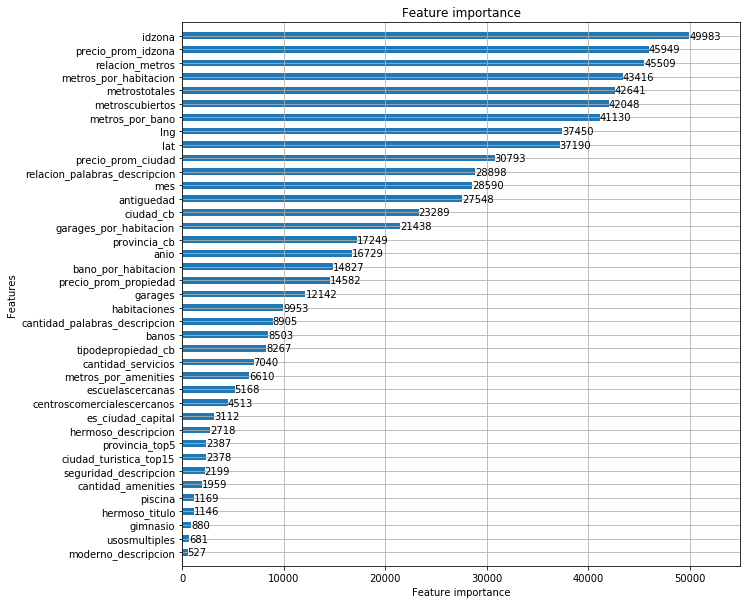

In [84]:
ax = lgb.plot_importance(LightGBM, height=0.5)
fig = ax.figure
fig.set_size_inches(10, 10)

In [85]:
LightGBM_pred_submit = LightGBM.predict(df_test, num_iteration=LightGBM.best_iteration)

In [86]:
resultado_submit = pd.DataFrame(index=df_test.index)
resultado_submit['id'] = id_col
#Inversa del Log en la salida
resultado_submit['target'] = np.exp(LightGBM_pred_submit)
display(resultado_submit.head())
resultado_submit.to_csv('../data/submitLightGBM.csv',index=False)

,id,target
0,4941,6.823532e+06
1,51775,9.573505e+05
2,115253,2.307214e+06
3,299321,1.168056e+06
4,173570,5.899328e+05


#### Score en Kaggle (features => score):
 **1.** ***Usando CatBoost encoded*** y ['id',
 'antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'seguridad_titulo',
 'moderno_titulo',
 'hermoso_titulo',
 'estado_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***573846.94092*** con 'learning_rate': 0.03,
    'num_leaves': 256,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.7,
    'subsample' : 0.7,
    'min_split_gain' : 0.01,
    'min_data_in_leaf':10,
***LOCAL MAE: 568518.75474***

 **2.** ***Usando CatBoost encoded y k=30*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***532012.21935*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 522286.09996***

 **3.** ***Usando CatBoost encoded y k=40*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***530839.77082*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 521747.30395***

 **4.** ***Usando CatBoost encoded y k=40*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad' (si value_count > 10),
 'precio_prom_propiedad',
 'precio_prom_idzona' (si value_count >=5),
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***503282.81680*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 489179.65249***

 **5.** ***Usando CatBoost encoded y k=40*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad' (si value_count > 10),
 'precio_prom_propiedad',
 'precio_prom_idzona' (si value_count >=2),
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***501835.72387*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 482907***

 **6.** ***Usando CatBoost encoded, k=40 y log precio*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad' (si value_count >= 10),
 'precio_prom_propiedad',
 'precio_prom_idzona' (si value_count >=2),
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'hermoso_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***495082.04784*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 477771.22426***